In [77]:
import numpy as np
import torch 
import pandas as pd
from pickle import FALSE, TRUE
from scipy.stats import norm 
import itertools
from itertools import repeat 
import scipy.stats as sts 
from torch.distributions import Normal  
import time
import cProfile as profile
import pstats
import seaborn as sns
import importlib

# for profiling
import cProfile, pstats, io
from pstats import SortKey

# helper functions from within the library
import helper
import init_params_tensor
import init_model
import params_search as ps
# import main_sim
import main_sim_tensor
import compute_prob_tensor

# reload these in case they are changed
importlib.reload(helper)
importlib.reload(compute_prob_tensor)
importlib.reload(init_params_tensor)
importlib.reload(init_model)
importlib.reload(main_sim_tensor)
importlib.reload(ps)

<module 'params_search' from '/Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/params_search.py'>

# model in main namespace

In [78]:
# set up meshed grids
grid_mu = torch.linspace(start = -1, end = 1, steps = 10)
grid_sigma = torch.linspace(start = 0.1, end = 1.8, steps = 11)
grid_y = torch.linspace(start = -1, end = 1, steps = 12)
grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 13)
mu_prior = 0.001
V_prior = 0.001 
alpha_prior = 1
beta_prior = 1

(meshed_grid_mu, 
        meshed_grid_sigma, 
        meshed_grid_y, 
        meshed_grid_epsilon) = torch.meshgrid(
            grid_mu,
            grid_sigma, 
            grid_y,
            grid_epsilon)

print(meshed_grid_mu.size())
print(meshed_grid_sigma.size())





torch.Size([10, 11, 12, 13])
torch.Size([10, 11, 12, 13])


In [79]:
# add priors 

lp_mu_sigma = compute_prob_tensor.score_mu_sigma(
    input_x = meshed_grid_mu,                                          
    input_sigma = meshed_grid_sigma, 
    mu  = mu_prior, 
    nu = V_prior, 
    alpha = alpha_prior,
    beta = beta_prior, 
    log = True
)

print(lp_mu_sigma.size())



torch.Size([10, 11, 12, 13])


In [80]:

lp_y_given_mu_sigma = compute_prob_tensor.score_y_given_mu_sigma(
            y_val = meshed_grid_y, 
            mu = meshed_grid_mu, 
            sigma = meshed_grid_sigma)

In [81]:
#p.add_lp_epsilon()
mu_epsilon = torch.tensor([0.001])
sd_epsilon = torch.tensor([4])

lp_epsilon = compute_prob_tensor.score_epsilon(
            epsilon = meshed_grid_epsilon,
            mu_epsilon = mu_epsilon, 
            sd_epsilon = sd_epsilon)

In [82]:
# p.add_priors()

prior = lp_mu_sigma + lp_epsilon

# print(lp_mu_sigma[:,0,:,0])

# now start functionalized model

In [83]:
# initialize parameters
params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = 11),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = 10), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 11), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 10), 
      hypothetical_obs_grid_n = 3, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

# add the various different cached bits
params.add_meshed_grid()
params.add_lp_mu_sigma()
params.add_y_given_mu_sigma()
params.add_lp_epsilon()
params.add_priors()

# initialize the model
stimuli = init_model.granch_stimuli(1, 'BBBBBB')
model = init_model.granch_model(500, s)

# in-namespace model loop for debugging

In [84]:
stimulus_idx = 0
t = 0 # following python tradition we are using 0-indexed
   
while t < params.max_observation and stimulus_idx < stimuli.n_trial: 
    # update model behavior with current t and current stimulus_idx 
    model.current_t = t 
    model.current_stimulus_idx = stimulus_idx
    model.update_model_stimulus_id()
    
    # make noisy observation and keep track 
    model.update_noisy_observation(params.epsilon)

    # get all possible observation on current stimulus 
    # if we didn't change stimulus 
    if model.current_t == 0 or (not model.if_same_stimulus_as_previous_t()): 
        model.update_possible_observations(params.epsilon, 
                                            params.hypothetical_obs_grid_n)
                        
    # updating the likelihood and posterior for the observed 
    model.update_likelihood(compute_prob_tensor.score_likelihood(model, params, hypothetical_obs = False))
    model.update_posterior(compute_prob_tensor.score_posterior(model,params, hypothetical_obs=False))
    
    # this iteration/index will currently work for only single feature
    n_possible_observations = len(model.possible_observations.tolist())

    # reset every timestep
    model.ps_kl = torch.tensor([])
    model.ps_pp = torch.tensor([])

    # loop through possible observations
    for i in range(0, n_possible_observations): 
        model.current_ps_obs = model.possible_observations[i]
        model.ps_likelihood = compute_prob_tensor.score_likelihood(model, params, hypothetical_obs=True, test = True)
        model.ps_posterior = compute_prob_tensor.score_posterior(model, params, hypothetical_obs=True)

        cur_ps_kl = compute_prob_tensor.kl_div(model.ps_posterior, model.all_posterior[model.current_t])
        model.ps_kl = torch.cat((model.ps_kl,cur_ps_kl.unsqueeze(0)))
        model.all_ps_kl[model.current_t] = model.ps_kl.tolist()

        cur_ps_pp = compute_prob_tensor.score_post_pred(model.current_ps_obs, model, params)
        model.ps_pp = torch.cat((model.ps_pp, cur_ps_pp.unsqueeze(0)))
        model.all_ps_pp[model.current_t] = model.ps_pp.tolist()

        model.ps_likelihood = None
        model.ps_posterior = None
        
    # compute EIG
    eig = torch.sum(model.ps_kl * model.ps_pp)
    model.update_model_eig(eig.item())

    # choice step: detereministic at present
    if (eig < params.world_EIGs): 
        # if EIG below threshold, increment stimulus
        stimulus_idx = stimulus_idx + 1
        model.update_model_decision(True)
    else: 
        # otherwise keep looking at this one
        model.update_model_decision(False)

    # increment time
    t = t + 1

AttributeError: 'granch_params' object has no attribute 'meshed_epsilon'

In [14]:
print(model.all_likelihood)

[tensor([-3.0499e+05, -8.3166e+00,  2.2176e+00,  ..., -6.5224e-01,
        -7.6496e-01, -8.6823e-01]), tensor([-4.0998e+05, -2.2622e+01, -1.5535e+00,  ..., -1.9918e+00,
        -2.2202e+00, -2.4284e+00]), tensor([-4.5498e+05, -3.6927e+01, -5.3247e+00,  ..., -3.3246e+00,
        -3.6713e+00, -3.9859e+00]), tensor([-4.9997e+05, -5.1233e+01, -9.0959e+00,  ..., -4.6512e+00,
        -5.1186e+00, -5.5408e+00]), tensor([-5.2496e+05, -6.5538e+01, -1.2867e+01,  ..., -5.9723e+00,
        -6.5623e+00, -7.0934e+00]), tensor([-5.2996e+05, -7.9843e+01, -1.6638e+01,  ..., -7.2883e+00,
        -8.0026e+00, -8.6438e+00]), tensor([-5.3495e+05, -9.4149e+01, -2.0409e+01,  ..., -8.5997e+00,
        -9.4398e+00, -1.0192e+01]), tensor([-5.3995e+05, -1.0845e+02, -2.4181e+01,  ..., -9.9069e+00,
        -1.0874e+01, -1.1738e+01]), tensor([-5.4494e+05, -1.2276e+02, -2.7952e+01,  ..., -1.1210e+01,
        -1.2306e+01, -1.3283e+01]), tensor([-5.4993e+05, -1.3707e+02, -3.1723e+01,  ..., -1.2511e+01,
        -1.3735

# Profiling of initial model with group_by_logsumexp

In [8]:
pr = cProfile.Profile()
pr.enable()
res = main_sim.granch_main_simulation(p, m, s)
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

NameError: name 'main_sim' is not defined

    stimulus_id       EIG Look_away  index_column
0             0  1.037876     False             0
1             0  1.114998     False             1
2             0  0.637033     False             2
3             0  0.274891     False             3
4             0    0.1151     False             4
..          ...       ...       ...           ...
495         NaN       NaN       NaN           495
496         NaN       NaN       NaN           496
497         NaN       NaN       NaN           497
498         NaN       NaN       NaN           498
499         NaN       NaN       NaN           499

[500 rows x 4 columns]


<AxesSubplot: xlabel='index_column', ylabel='EIG'>

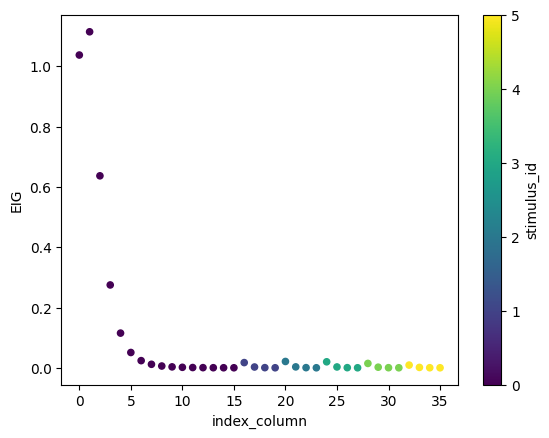

In [ ]:
res.behavior['index_column'] = res.behavior.index
res.behavior.plot.scatter(x = "index_column", y = "EIG", c = "stimulus_id")

# Profiling of improved logsumexp

In [ ]:
pr = cProfile.Profile()
pr.enable()
res = main_sim.granch_main_simulation(p, m, s)
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         157214 function calls (154501 primitive calls) in 9.998 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    9.998    4.999 /Users/mcfrank/Projects/pokebaby/looking_time_models/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406(run_code)
        2    0.000    0.000    9.998    4.999 {built-in method builtins.exec}
        1    0.000    0.000    9.998    9.998 /var/folders/c1/4_sgh_lx3h5c7c8r9w3xs6f00000gq/T/ipykernel_57633/2873141792.py:3(<module>)
        1    0.009    0.009    9.998    9.998 /Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/main_sim.py:39(granch_main_simulation)
      252    0.050    0.000    8.420    0.033 /Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/helper.py:49(group_by_logsumexp_improved)
  504/252    0.002    0.000    6.874    0.027 /Users/mcfrank/Projects/pokebaby/looking_time_models/.venv/lib/python3.9/

<AxesSubplot: xlabel='index_column', ylabel='EIG'>

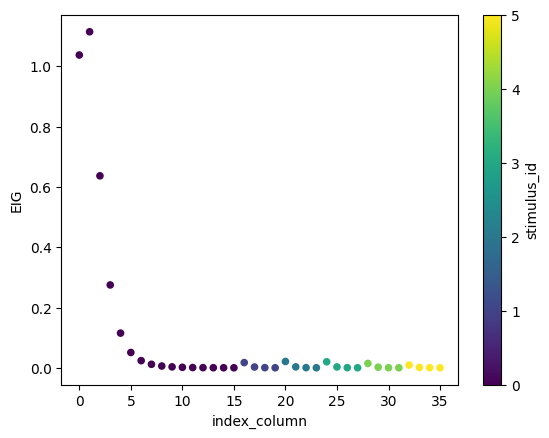

In [ ]:
res.behavior['index_column'] = res.behavior.index
res.behavior.plot.scatter(x = "index_column", y = "EIG", c = "stimulus_id")